In [1]:
from registration_framework import Registration
from pso_optim import PSO_optim
from utils.tools import Tools
from common_config import CommonConfig

common_cfg = CommonConfig() 
# 进行图像匹配的操作
config = Tools.load_yaml_config("matched_config.yaml")
res_path = f"{config.data_save_path}/{config.record_id}"
file_name = f"{config.record_id}_config.yaml"
Tools.save_obj_yaml(res_path, file_name, config)

sample_range = common_cfg.get_range(config.cement_sample_index)
total_image_num = sample_range[1] - sample_range[0]
sample_interval = config.sample_interval
# 先进行基操，看能够到达什么水平
loop_times = total_image_num // sample_interval

start_index = sample_range[0]

# 貌似没啥问题，测试一波

index_array = []
# 记录所有的编号
for i in range(loop_times):
    slice_index = start_index + i * sample_interval
    index_array.append(slice_index)

registration = Registration(config, index_array)

Folder 'D:/workspace/ml-workspace/registration/result/matched/matched-sample4' already exists and the file 'matched-sample4_config.yaml' is not present.
r_width: 256, r_height: 256


In [4]:
import threading


share_records_out = []

psos = []
# 多线程来跑，假设先跑两个
for i in range(loop_times):
    slice_index = start_index + i * sample_interval
    pso = PSO_optim(config, share_records_out)
    registration.set_optim_algorithm(pso, slice_index)
    psos.append(pso)

threads = []
for pso in psos:
    thread = threading.Thread(target=pso.run)
    threads.append(thread)
    thread.start()

# 等待所有线程完成
for thread in threads:
    thread.join()

Folder 'D:/workspace/ml-workspace/registration/result/matched/matched-sample4' already exists and the file '165_start_particle_pos.csv' is not present.
Folder 'D:/workspace/ml-workspace/registration/result/matched/matched-sample4' already exists and the file '485_start_particle_pos.csv' is not present.
Folder 'D:/workspace/ml-workspace/registration/result/matched/matched-sample4' already exists and the file '965_start_particle_pos.csv' is not present.
Folder 'D:/workspace/ml-workspace/registration/result/matched/matched-sample4' already exists and the file '205_start_particle_pos.csv' is not present.
Folder 'D:/workspace/ml-workspace/registration/result/matched/matched-sample4' already exists and the file '185_start_particle_pos.csv' is not present.
Folder 'D:/workspace/ml-workspace/registration/result/matched/matched-sample4' already exists and the file '725_start_particle_pos.csv' is not present.
iterations: 0, fitness: 0.010664921648933824, params: tensor([ 77.6523,  48.3954, 212.94

In [5]:

file_name = "all_best_fitness_recorded.csv"
Tools.save_params2df(share_records_out, ["ct_slice_index", "x", "y", "rotation", "fitness"], res_path, file_name)

Folder 'D:/workspace/ml-workspace/registration/result/matched/matched-sample4' already exists and the file 'all_best_fitness_recorded.csv' is not present.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 创建 t-SNE 实例
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000)

(<Axes: title={'center': 'end plot'}>,
 Text(0.5, 1.0, 'end plot'))

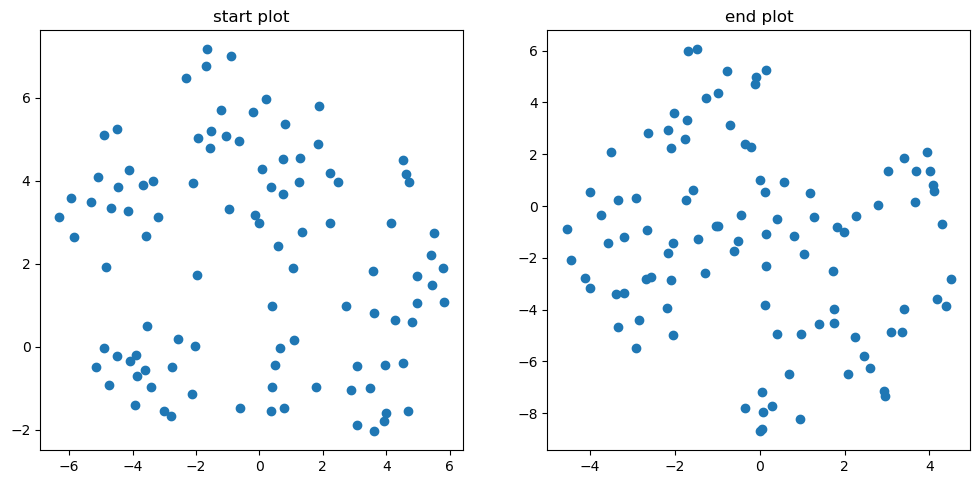

In [36]:

# 对点进行可视化其中优化的所有点进行可视化

start_csv_path = "D:/workspace/ml-workspace/registration/result/matched/matched-sample4/585_start_particle_pos.csv"
end_csv_path = "D:/workspace/ml-workspace/registration/result/matched/matched-sample4/585_end_particle_pos.csv"

def load_csv2_np_datas(csv_path):
    # 读取文件
    pso_params_data = pd.read_csv(csv_path)
    x = pso_params_data["x"].to_numpy()
    y = pso_params_data["y"].to_numpy()
    rot = pso_params_data["rotation"].to_numpy()
    return np.stack((x, y, rot)).transpose()

high_dim_datas_start = load_csv2_np_datas(start_csv_path)
high_dim_datas_end = load_csv2_np_datas(end_csv_path)

# 应用 t-SNE 进行降维
X_tsne_start = tsne.fit_transform(high_dim_datas_start)
X_tsne_end = tsne.fit_transform(high_dim_datas_end)


# 绘制散点图
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1), plt.scatter(X_tsne_start[:, 0], X_tsne_start[:, 1]), plt.title('start plot')
plt.subplot(2, 2, 2), plt.scatter(X_tsne_end[:, 0], X_tsne_end[:, 1]), plt.title('end plot')

